# Business Understanding

# Data Engineering

## Import Libraries

In [232]:
# import libraries required to load, transform, analyze and plot data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context='paper', style='darkgrid', 
        rc={'figure.facecolor':'white'}, font_scale=1.2)

import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import en_core_web_sm
from spacy.tokenizer import _get_regex_pattern
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.preprocessing import text, sequence
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Embedding, LeakyReLU
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, SpatialDropout1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as k


In [2]:
# remove scientific notation and restrictions on df rows/columns display
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('display.max_colwidth', 150)

## Dataframe Basics

### Load File

In [3]:
# load primary source file to df, renaming columns, dropping non-ASCII
col_names = ['tweet_text', 'directed_at', 'emotion_label']
tweets = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding= 'unicode_escape', names=col_names, header=0)
tweets.head()


,tweet_text,directed_at,emotion_label
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


### Data Values

In [4]:
# review data types and null counts
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet_text     9092 non-null   object
 1   directed_at    3291 non-null   object
 2   emotion_label  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
# drop nan tweets from dataframe
tweets.dropna(subset = ['tweet_text'], inplace=True)
tweets.shape

(9092, 3)

In [6]:
# check value counts by column
print(tweets['directed_at'].value_counts(normalize=True, dropna=False))

NaN                               0.638
iPad                              0.104
Apple                             0.073
iPad or iPhone App                0.052
Google                            0.047
iPhone                            0.033
Other Google product or service   0.032
Android App                       0.009
Android                           0.009
Other Apple product or service    0.004
Name: directed_at, dtype: float64


In [7]:
# create brand feature
tweets['directed_at'].fillna('None', inplace=True)
brand_map = {'iPad': 'Apple', 'Apple': 'Apple', 'iPad or iPhone App': 'Apple', 
             'Google': 'Google', 'iPhone': 'Apple', 
             'Other Google product or service': 'Google',
            'Android App': 'Google', 'Android': 'Google',
             'Other Apple product or service': 'Apple',
             'None': 'None'
            }
tweets['brand'] = tweets.directed_at.map(brand_map, na_action='ignore')

In [8]:
# clean emotion labels
tweets['emotion_label'].replace({'No emotion toward brand or product': 'Neutral',
                                 'Positive emotion': 'Positive', 
                                 'Negative emotion': 'Negative', 
                                 'I can\'t tell': 'Unknown'}, inplace=True)

# check value counts by column
print(tweets['emotion_label'].value_counts(normalize=True, dropna=False))

Neutral    0.593
Positive   0.328
Negative   0.063
Unknown    0.017
Name: emotion_label, dtype: float64


In [9]:
# check value counts by column
tweets.groupby(by=['brand', 'emotion_label'])['tweet_text'].count()

brand   emotion_label
Apple   Negative          388
        Neutral            65
        Positive         1949
        Unknown             7
Google  Negative          131
        Neutral            26
        Positive          723
        Unknown             2
None    Negative           51
        Neutral          5297
        Positive          306
        Unknown           147
Name: tweet_text, dtype: int64

## Tweet Text Clean

In [10]:
def remove_punctuation(x):
    """
    Helper function to remove punctuation from a string x: any string
    """
    punctuation = set(string.punctuation) # punctuation of English language
    punctuation.remove('#') # remove # so hashtags remain in x

    x = re.sub('@[A-Za-z0-9]+', '', x) # remove @mention users
    x = re.sub(r'http\S+', '', x) # remove URL references
    x = re.sub(r'\b[0-9]+\b', '', x) # remove stand-alone numbers  
    x = ''.join(ch for ch in x if ch not in punctuation) # remove punctuation
    return x

In [11]:
# function to clean text
def  clean_text(df, text_field, new_text_field):
    df[new_text_field] = df[text_field].str.lower()
    df[new_text_field] = df[new_text_field].apply(remove_punctuation) 
    return df

In [12]:
tweets_clean = clean_text(tweets, 'tweet_text', 'tweet_text_clean')
tweets_clean.head()

,tweet_text,directed_at,emotion_label,brand,tweet_text_clean
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,Apple,i have a 3g iphone after hrs tweeting at #riseaustin it was dead i need to upgrade plugin stations at #sxsw
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,Apple,know about awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at #sxsw
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,Apple,can not wait for #ipad also they should sale them down at #sxsw
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,Apple,i hope this years festival isnt as crashy as this years iphone app #sxsw
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive,Google,great stuff on fri #sxsw marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress


In [13]:
# 
nlp = en_core_web_sm.load()
print(nlp.pipe_names)

# get default pattern for tokens that don't get split
re_token_match = _get_regex_pattern(nlp.Defaults.token_match)
# add your patterns (here: hashtags and in-word hyphens)
re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"

# overwrite token_match function of the tokenizer
nlp.tokenizer.token_match = re.compile(re_token_match).match

['tagger', 'parser', 'ner']


In [14]:
# 
stops_sp = nlp.Defaults.stop_words
print(f'spaCy Stopword Count: {len(stops_sp)}')

def clean_token(doc):
    return [token.lemma_ for token in doc if not token.is_stop 
            and not token.is_punct and not token.is_digit 
            and not token.is_space]

tweets['tokens_sp'] = [clean_token(nlp(row)) for row in tweets.tweet_text_clean.apply(str)]

tweets.head()

spaCy Stopword Count: 326


,tweet_text,directed_at,emotion_label,brand,tweet_text_clean,tokens_sp
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,Apple,i have a 3g iphone after hrs tweeting at #riseaustin it was dead i need to upgrade plugin stations at #sxsw,"[g, iphone, hrs, tweet, #riseaustin, dead, need, upgrade, plugin, station, #sxsw]"
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,Apple,know about awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at #sxsw,"[know, awesome, ipadiphone, app, will, likely, appreciate, design, give, free, ts, #sxsw]"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,Apple,can not wait for #ipad also they should sale them down at #sxsw,"[wait, #ipad, sale, #sxsw]"
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,Apple,i hope this years festival isnt as crashy as this years iphone app #sxsw,"[hope, year, festival, not, crashy, year, iphone, app, #sxsw]"
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive,Google,great stuff on fri #sxsw marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress,"[great, stuff, fri, #sxsw, marissa, mayer, google, tim, oreilly, tech, booksconference, amp, matt, mullenweg, wordpress]"


In [15]:
# 
word_dict = {}

# Loop through all the tags
for i, row in tweets['tokens_sp'].iteritems():
    for word in row:
        if word not in word_dict:
            word_dict[word] = 1
        else:
            word_dict[word] +=1

word_counts = sorted(word_dict.items(), key=lambda kv: kv[1], reverse=True)
print(f'Total words: {len(word_counts)}')
word_counts[:25]

Total words: 9533


[('#sxsw', 8947),
 ('link', 4300),
 ('rt', 2953),
 ('ipad', 2245),
 ('google', 2102),
 ('apple', 1826),
 ('store', 1501),
 ('iphone', 1258),
 ('new', 1093),
 ('app', 992),
 ('austin', 848),
 ('launch', 819),
 ('amp', 724),
 ('social', 623),
 ('popup', 600),
 ('today', 573),
 ('open', 514),
 ('not', 496),
 ('sxsw', 481),
 ('network', 472),
 ('line', 446),
 ('circle', 444),
 ('android', 435),
 ('#apple', 409),
 ('party', 380)]

# Data Analysis

# Predictive Models

## Train-Test Split

In [16]:
# filter tweets for identifiable emotions only (drop unknown)
sentiments = ['Positive', 'Negative', 'Neutral']
tweets_f = tweets[tweets['emotion_label'].isin(sentiments)]

# create X and y (one-hot encoded for 3 classes)
Xt = tweets_f['tokens_sp']
X = tweets_f['tweet_text_clean']
y = pd.get_dummies(tweets_f['emotion_label'])
print(X.iloc[:3], y.iloc[:3])

0           i have a 3g iphone after  hrs tweeting at #riseaustin it was dead  i need to upgrade plugin stations at #sxsw
1     know about   awesome ipadiphone app that youll likely appreciate for its design also theyre giving free ts at #sxsw
2                                                        can not wait for #ipad  also they should sale them down at #sxsw
Name: tweet_text_clean, dtype: object    Negative  Neutral  Positive
0         1        0         0
1         0        0         1
2         0        0         1


In [18]:
# Split into training and test sets for tokenized words (spacy)
SEED = 19
Xt_train, Xt_test, yt_train, yt_test = train_test_split(
    Xt, y, test_size=0.20, stratify=y, random_state=SEED)
print(f'Xt_train: {Xt_train.shape} Xt_test: {Xt_test.shape} ' 
      f'yt_train: {yt_train.shape} yt_test: {yt_test.shape}')

Xt_train: (7148,) Xt_test: (1788,) yt_train: (7148, 3) yt_test: (1788, 3)


In [19]:
# Split into training and test sets for cleaned text
SEED = 19
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED)
print(f'X_train: {X_train.shape} X_test: {X_test.shape} ' 
      f'y_train: {y_train.shape} y_test: {y_test.shape}')

X_train: (7148,) X_test: (1788,) y_train: (7148, 3) y_test: (1788, 3)


## Model Functions

In [40]:
# return max length (words) of a feature
def FindMaxLength(lst):
    maxList = max(lst, key = lambda i: len(i))
    maxLength = len(maxList)    
    return maxLength

## m1 - LSTM Embed Tweets Cleaned

In [57]:
# keras tokenize sequences with padding
t1 = text.Tokenizer(oov_token=1)
t1.fit_on_texts(X_train)
t1_tweets = t1.texts_to_sequences(X_train)
X_train_m1 = sequence.pad_sequences(t1_tweets, padding='post') # longest 23

In [67]:
# set parameters for model input
vocab_size_m1 = len(t1.word_index) + 1
input_length_m1 = FindMaxLength(X_train_m1)

print(f'Token count: {t1.document_count} | '
      f'Vocab size: {vocab_size_m1} | '
      f'Input length: {input_length_m1} '
     )

Token count: 7148 | Vocab size: 9557 | Input length: 30 


In [68]:
# instantiate keras sequential LSTM model layers with embeddings
m1 = Sequential(name="m1_seq_lstm")
m1.add(Embedding(input_dim=vocab_size_m1, 
                    output_dim=128, 
                    input_length=input_length_m1
                    ))
m1.add(LSTM(64, return_sequences=True))
m1.add(GlobalMaxPool1D()) # downsamples input by taking the maximum value over the time dimension
m1.add(Dropout(0.05)) # drop out lower or remove (regularization)
m1.add(Dense(32, activation='relu'))
m1.add(Dense(3, activation='softmax'))

In [69]:
# compile model and print summary
m1.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
m1.summary()

Model: "m1_seq_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 30, 128)           1223296   
_________________________________________________________________
lstm_10 (LSTM)               (None, 30, 64)            49408     
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 64)                0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 99        
Total params: 1,274,883
Trainable params: 1,274,883
Non-trainable params: 0
_____________________________________________

In [70]:
# Define the callbacks, early stopping and save final model
early_stop_m1 = [EarlyStopping(monitor='val_loss', patience=6), 
                  ModelCheckpoint(filepath='best_model_m1.h5', monitor='val_loss',
                                  save_best_only=True)]

m1.fit(X_train_m1, y_train, epochs=50, callbacks=early_stop_m1,
          validation_split=0.15)

/Users/cutterback/opt/anaconda3/envs/p37env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6075 samples, validate on 1073 samples
Epoch 1/50
6075/6075 [==============================] - 20s 3ms/step - loss: 0.8298 - accuracy: 0.6127 - val_loss: 0.7629 - val_accuracy: 0.6486
Epoch 2/50
6075/6075 [==============================] - 19s 3ms/step - loss: 0.6369 - accuracy: 0.7251 - val_loss: 0.6972 - val_accuracy: 0.6859
Epoch 3/50
6075/6075 [==============================] - 19s 3ms/step - loss: 0.4345 - accuracy: 0.8285 - val_loss: 0.7648 - val_accuracy: 0.6710
Epoch 4/50
6075/6075 [==============================] - 19s 3ms/step - loss: 0.2998 - accuracy: 0.8815 - val_loss: 0.8962 - val_accuracy: 0.6775
Epoch 5/50
6075/6075 [==============================] - 19s 3ms/step - loss: 0.2303 - accuracy: 0.9050 - val_loss: 0.9377 - val_accuracy: 0.6626
Epoch 6/50
6075/6075 [==============================] - 19s 3ms/step - loss: 0.1922 - accuracy: 0.9180 - val_loss: 1.0444 - val_accuracy: 0.6608
Epoch 7/50
6075/6075 [==============================] - 19s 3ms/step - loss: 0.163

## m2 - LSTM Embed Tweet Tokens

In [41]:
# keras tokenize sequences with padding
t2 = text.Tokenizer(oov_token=1)
t2.fit_on_texts(Xt_train)
t2_tweets = t2.texts_to_sequences(Xt_train)
Xt_train_m2 = sequence.pad_sequences(t2_tweets, padding='post') # longest 23

In [42]:
# set parameters for model input
vocab_size = len(t2.word_index) + 1
input_length = FindMaxLength(Xt_train)

print(f'Token count: {t2.document_count} | '
      f'Vocab size: {vocab_size} | '
      f'Input length: {input_length} '
     )

Token count: 7148 | Vocab size: 8497 | Input length: 23 


In [47]:
# instantiate keras sequential LSTM model layers with embeddings
model = Sequential(name="m2_seq_lstm")
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=64, 
                    input_length=input_length
                    ))
model.add(LSTM(64, return_sequences=True))
model.add(GlobalMaxPool1D()) # downsamples input by taking the maximum value over the time dimension
model.add(Dropout(0.05)) # drop out lower or remove (regularization)
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [48]:
# compile model and print summary
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "m2_seq_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 23, 64)            543808    
_________________________________________________________________
lstm_6 (LSTM)                (None, 23, 64)            33024     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 64)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 99        
Total params: 579,011
Trainable params: 579,011
Non-trainable params: 0
_________________________________________________

In [49]:
# Define the callbacks, early stopping and save final model
early_stop = [EarlyStopping(monitor='val_loss', patience=6), 
                  ModelCheckpoint(filepath='best_model_m2.h5', monitor='val_loss',
                                  save_best_only=True)]

model.fit(Xt_train_m2, yt_train, epochs=50, callbacks=early_stop,
          validation_split=0.15) 

/Users/cutterback/opt/anaconda3/envs/p37env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6075 samples, validate on 1073 samples
Epoch 1/50
6075/6075 [==============================] - 15s 2ms/step - loss: 0.8475 - accuracy: 0.6086 - val_loss: 0.7833 - val_accuracy: 0.6384
Epoch 2/50
6075/6075 [==============================] - 13s 2ms/step - loss: 0.6647 - accuracy: 0.7091 - val_loss: 0.7404 - val_accuracy: 0.6785
Epoch 3/50
6075/6075 [==============================] - 13s 2ms/step - loss: 0.4669 - accuracy: 0.8089 - val_loss: 0.7916 - val_accuracy: 0.6766
Epoch 4/50
6075/6075 [==============================] - 13s 2ms/step - loss: 0.3402 - accuracy: 0.8649 - val_loss: 0.8259 - val_accuracy: 0.6785
Epoch 5/50
6075/6075 [==============================] - 13s 2ms/step - loss: 0.2624 - accuracy: 0.8895 - val_loss: 0.9877 - val_accuracy: 0.6822
Epoch 6/50
6075/6075 [==============================] - 13s 2ms/step - loss: 0.2147 - accuracy: 0.9108 - val_loss: 0.9733 - val_accuracy: 0.6673
Epoch 7/50
6075/6075 [==============================] - 13s 2ms/step - loss: 0.182

Notes 
- Visualize n-grams or word clouts or frequency association
- Word embeddings - Glove vectors
- Encode with Bag of Words/TGIDF with RF (helps with interpretability) - helps link complexity; still could use NN (basic dense)

## m3 - LSTM Embed Glove

In [105]:
# establish total vocabulary prior to fetching Glove vectors
t0 = text.Tokenizer(oov_token=1)
t0.fit_on_texts(X)
vocab = list(t0.word_counts.keys())
print(f'Total tweet vocabulary is: {len(vocab)}')

Total tweet vocabulary is: 10563


In [106]:
# create glove dictionary of embedding vectors for vocab list
glove_file = 'data/glove.twitter.27B.200d.txt'
glove = {}
with open(glove_file, 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in vocab:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [121]:
# establish total vocabulary prior to fetching Glove vectors
t3 = text.Tokenizer(oov_token=1)
t3.fit_on_texts(X_train)
t3_tweets = t3.texts_to_sequences(X_train)
X_train_m3 = sequence.pad_sequences(t3_tweets, padding='post') # longest 23

In [122]:
# 
vocab_size = len(t3.word_index) + 1
glove_dim = len(next(iter(glove.values())))  # Number of dimensions of the GloVe word embeddings
input_length = FindMaxLength(X_train_m3)

emb_matrix = np.zeros((vocab_size, glove_dim))
for w, i in t3.word_index.items():
    vect = glove.get(w)
    if vect is not None:
        emb_matrix[i] = vect

print(f'Tweet count: {t3.document_count} | '
      f'Vocab size: {vocab_size} | '
      f'Input length: {input_length} '
     )

Tweet count: 7148 | Vocab size: 9557 | Input length: 30 


In [253]:
# instantiate keras sequential LSTM model layers with embeddings
m3 = Sequential(name="m3_seq_lstm_glove")
m3.add(Embedding(input_dim=vocab_size, 
                 output_dim=glove_dim, 
                 input_length=input_length,
                 weights=[emb_matrix], 
                 trainable=False
                    ))
m3.add(SpatialDropout1D(0.2))
m3.add(LSTM(128, return_sequences=True))
m3.add(Bidirectional(LSTM(128, dropout=0.15, recurrent_dropout=0.15, return_sequences=True)))
m3.add(GlobalMaxPool1D()) # downsamples input by taking the maximum value over the time dimension
m3.add(Dense(64, activation="relu")) 
m3.add(Dense(32, activation="relu"))
m3.add(Dense(3, activation='softmax'))

In [256]:
# compile model and print summary
opt = optimizers.SGD(lr=0.001, momentum=0.95) 
m3.compile(loss='categorical_crossentropy', optimizer=opt, 
              metrics=['accuracy'])
m3.summary()
# RMSprop(learning_rate=0.001, rho=0.9)

Model: "m3_seq_lstm_glove"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 30, 200)           1911400   
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 30, 200)           0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 30, 128)           168448    
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 30, 256)           263168    
_________________________________________________________________
global_max_pooling1d_27 (Glo (None, 256)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_67 (Dense)             (None, 32)          

In [255]:
# Define the callbacks, early stopping and save final model
early_stop_m3 = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), 
                  ModelCheckpoint(filepath='best_model_m3.h5', monitor='val_loss',
                                  save_best_only=True)]

# optimizer=RMSprop(lr=learning_rate)
m3_fit = m3.fit(X_train_m3, y_train, epochs=50, callbacks=early_stop_m3,
          validation_split=0.15, shuffle=True, batch_size=64)

Train on 6075 samples, validate on 1073 samples
Epoch 1/50
6075/6075 [==============================] - 38s 6ms/step - loss: 0.8737 - accuracy: 0.5942 - val_loss: 0.8430 - val_accuracy: 0.5983
Epoch 2/50
1536/6075 [======>.......................] - ETA: 23s - loss: 0.8297 - accuracy: 0.6022

KeyboardInterrupt: 

In [213]:
m3_hist = m3_fit.history
m3_hist.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [219]:
y_train.head()

,Negative,Neutral,Positive
6929,0,1,0
5841,0,1,0
2865,1,0,0
4306,0,1,0
8888,0,0,1


In [214]:
print(k.eval(m3.optimizer.lr))

0.001


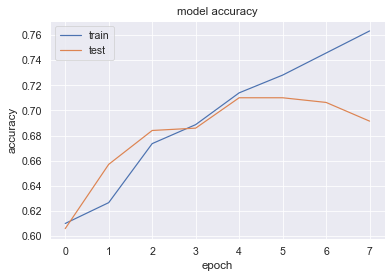

In [215]:
# summarize history for accuracy
plt.plot(m3_hist['accuracy'])
plt.plot(m3_hist['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
m.load_weights(checkpoint_path)
    predictions = m.predict(X_test, verbose=1)
    print('Validation Loss:', log_loss(y_test, predictions))
    print('Test Accuracy', (predictions.argmax(axis = 1) == y_test.argmax(axis = 1)).mean())
    print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions.argmax(axis = 1), average='weighted'))
    plot_confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1), classes=encoder.classes_)
    plt.show()    